## Лабораторная работа № 1
### Изучение принципов работы байесовских сетей c использованием фреймворка Pyro и библиотеки ArviZ

#### Задачи работы:
1. Познакомиться с байесовским моделированием и организацией байесовских сетей.
2. Изучить принципы создания байесовских моделей для решения стандартных задач машинного обучения.
3. Познакомиться с байесовским подходом к заполнению пропусков в данных.
4. Получить навыки создания и обучения моделей, а также получения результатов предсказания на их основе, с использованием фреймворка Pyro.
5. Получить навыки интерпретации байесовских моделей с использованием библиотеки ArviZ.

Устанавливаем фреймворк вероятностного программирования [Pyro](https://pyro.ai/):

In [168]:
!pip install pyro-ppl

Подключаем библиотеки анализа и визуализации данных, необходимые в процессе работы.

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import torch
import pyro
from pyro import distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

%matplotlib inline

Уточняем версию фреймворка Pyro.

In [170]:
pyro.__version__

'1.9.0'

https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset
# В работе анализируется датасет [Credit Risk Dataset](https://www.kaggle.com/datasets/laotse/credit-risk-dataset), который содержит информацию о клиентах, получивших кредит.

Данный датасет был разделен на две части (train и predict), предназначенные для обучения байесовской модели и получения по ней предсказаний соответственно.

Скачиваем [тренировочный](https://drive.google.com/file/d/1HnBdQodlt3MyAd6NVw0qOKxQYVbc7X8s/view?usp=sharing) и [тестовый](https://drive.google.com/file/d/1n9XjptSj8j4BL1gFwxXBFN69MtjsSPQE/view?usp=sharing) датасеты в локальную папку.

Загрузим датасет для обучения модели и посмотрим на него.

In [171]:
!gdown 1HnBdQodlt3MyAd6NVw0qOKxQYVbc7X8s
!gdown 1n9XjptSj8j4BL1gFwxXBFN69MtjsSPQE

Downloading...
From: https://drive.google.com/uc?id=1HnBdQodlt3MyAd6NVw0qOKxQYVbc7X8s
To: /content/credit_risk_dataset_train.csv
100% 1.67M/1.67M [00:00<00:00, 78.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n9XjptSj8j4BL1gFwxXBFN69MtjsSPQE
To: /content/credit_risk_dataset_predict.csv
100% 131k/131k [00:00<00:00, 92.7MB/s]


Описание столбцов датасета представлено ниже.

In [172]:
df_train_name = "/content/train_diabetes.csv"
df_train = pd.read_csv(df_train_name, sep=",")
df_train

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Male,12.00,0,0,No Info,27.32,6.1,160,0
1,Male,54.00,0,0,not current,36.58,4.8,155,0
2,Female,38.00,0,0,No Info,22.31,3.5,145,0
3,Female,41.00,0,0,No Info,23.62,6.0,155,0
4,Female,80.00,1,1,never,22.67,7.5,160,1
...,...,...,...,...,...,...,...,...,...
79995,Male,0.08,0,0,No Info,11.10,6.1,80,0
79996,Female,23.00,0,0,former,21.01,6.2,90,0
79997,Female,45.00,0,0,never,29.06,6.2,158,0
79998,Female,46.00,0,0,never,36.09,6.0,126,0


   |**Признак**|**Значение**|
   |-----------|------------|
   | gender | Пол |
   | Age | Возраст |
   | hypertension | Гипертония  |
   | heart_disease | Болезни сердца |
   | smoking_history | История курения |
   | bmi | ИМТ (индекс массы тела) |
   | HbA1c_level | Уровень HbA1c (гемоглобина A1c) |
   | blood_glucose_level | Уровень глюкозы в крови |
   | diabetes | Диабет |

В датасете наблюдаются признаки:

* **количественные**: возраст, ИМТ, уровень HbA1c, уровень глюкозы в крови.
* **категориальные**: пол, гипертония, болезни сердца, история курения, диабет.

Взглянем на формат столбцов датасета.

In [173]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               80000 non-null  object 
 1   age                  80000 non-null  float64
 2   hypertension         80000 non-null  int64  
 3   heart_disease        80000 non-null  int64  
 4   smoking_history      80000 non-null  object 
 5   bmi                  75341 non-null  float64
 6   HbA1c_level          80000 non-null  float64
 7   blood_glucose_level  80000 non-null  int64  
 8   diabetes             80000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 5.5+ MB


Посмотрим, содержат ли столбцы пропущенные значения.

In [174]:
df_train.isnull().sum()

gender                    0
age                       0
hypertension              0
heart_disease             0
smoking_history           0
bmi                    4659
HbA1c_level               0
blood_glucose_level       0
diabetes                  0
dtype: int64

Видно, ИМТ (индекс массы тела) указана не для всех пациентов. Пропущенные значения будем заполнять в дальнейшем с применением байесовской модели.

Посмотрим на статистику данных.

In [175]:
df_train.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,80000.000000,80000.000000,80000.000000,75341.000000,80000.000000,80000.000000,80000.000000
mean,41.828501,0.074725,0.039575,27.317309,5.526124,138.114137,0.084462
std,22.522356,0.262949,0.194960,6.648384,1.069802,40.649143,0.278082
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.000000,0.000000,29.560000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


Максимальный ИМТ и уровень глюкозы в крови вызывает сомнения...

Выведем несколько пациентов, отсортированных по ИМТ в порядке убывания и отсортированных по уровню глюкозы в крови по убыванию.

In [176]:
df_train.sort_values(by="bmi", ascending=False).head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
73438,Male,7.0,0,0,No Info,95.69,6.1,130,0
69329,Male,16.0,0,0,No Info,95.22,4.5,90,0
28866,Male,38.0,0,0,never,91.82,6.0,160,0
67647,Female,45.0,0,0,never,88.72,7.0,300,1
27254,Female,34.0,0,0,No Info,87.70,6.0,126,0
36546,Male,19.0,0,0,No Info,87.51,3.5,85,0
42318,Male,49.0,0,0,former,83.74,6.8,155,1
21001,Female,48.0,0,0,never,81.73,6.5,130,1
64168,Female,36.0,0,0,never,79.46,6.2,220,1
24787,Female,25.0,0,0,current,75.78,6.1,100,0


In [177]:
df_train.sort_values(by="blood_glucose_level", ascending=False).head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
53164,Male,58.0,0,0,never,34.30,6.2,300,1
60496,Female,79.0,0,0,former,28.48,6.6,300,1
38325,Male,72.0,0,1,ever,23.54,6.6,300,1
50769,Female,68.0,1,0,never,31.82,6.2,300,1
57300,Male,60.0,0,0,never,27.32,6.5,300,1
38294,Male,22.0,0,0,No Info,32.14,6.8,300,1
66411,Female,80.0,0,1,never,23.50,5.7,300,1
38279,Female,45.0,0,0,current,38.33,9.0,300,1
45728,Male,63.0,0,1,No Info,27.32,6.6,300,1
23539,Female,31.0,0,0,current,48.41,5.8,300,1


Определим выбросы в этих двух признаках с помощью Межквартильного диапазона (IQR)

In [178]:
colmn_name = 'bmi'
#IQR
Q1 = np.percentile(df_train[colmn_name], 25, method='midpoint')
Q3 = np.percentile(df_train[colmn_name], 75, method='midpoint')
IQR = Q3 - Q1

# Above Upper bound
upper = Q3+1.5*IQR
upper_array = np.array(df_train[colmn_name] >= upper)
print("Upper Bound:", upper)
print(upper_array.sum())

# Below Lower bound
lower = Q1-1.5*IQR
lower_array = np.array(df_train[colmn_name] <= lower)
print("Lower Bound:", lower)
print(lower_array.sum())

Upper Bound: nan
0
Lower Bound: nan
0


Выбросов в признаке bmi не обнаружено.

In [179]:
colmn_name = 'blood_glucose_level'
#IQR
Q1 = np.percentile(df_train[colmn_name], 25, method='midpoint')
Q3 = np.percentile(df_train[colmn_name], 75, method='midpoint')
IQR = Q3 - Q1

# Above Upper bound
upper = Q3+1.5*IQR
upper_array = np.array(df_train[colmn_name] >= upper)
print("Upper Bound:", upper)
print(upper_array.sum())


# Below Lower bound
lower = Q1-1.5*IQR
lower_array = np.array(df_train[colmn_name] <= lower)
print("Lower Bound:", lower)
print(lower_array.sum())

Upper Bound: 247.5
1615
Lower Bound: 11.5
0


В признаке "Уровень глюкозы в крови" количество выбросов составляет чуть больше 2%. Удалим их из датасета.

In [180]:
upper_array = np.where(df_train['blood_glucose_level'] >= upper)[0]
lower_array = np.where(df_train['blood_glucose_level'] <= lower)[0]

df_train.drop(index=upper_array, inplace=True)
df_train.drop(index=lower_array, inplace=True)

df_train.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,78385.000000,78385.000000,78385.000000,73823.000000,78385.000000,78385.000000,78385.000000
mean,41.436054,0.071276,0.037278,27.215813,5.497619,135.184168,0.065599
std,22.490288,0.257288,0.189442,6.586934,1.050855,35.438230,0.247582
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,23.000000,0.000000,0.000000,23.530000,4.800000,100.000000,0.000000
50%,42.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.390000,6.200000,158.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,240.000000,1.000000


Посмотрим на количество значений категориальных признаков.

In [181]:
df_train

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Male,12.00,0,0,No Info,27.32,6.1,160,0
1,Male,54.00,0,0,not current,36.58,4.8,155,0
2,Female,38.00,0,0,No Info,22.31,3.5,145,0
3,Female,41.00,0,0,No Info,23.62,6.0,155,0
4,Female,80.00,1,1,never,22.67,7.5,160,1
...,...,...,...,...,...,...,...,...,...
79995,Male,0.08,0,0,No Info,11.10,6.1,80,0
79996,Female,23.00,0,0,former,21.01,6.2,90,0
79997,Female,45.00,0,0,never,29.06,6.2,158,0
79998,Female,46.00,0,0,never,36.09,6.0,126,0


In [182]:
for col in ["gender",
            "hypertension",
            "heart_disease",
            "smoking_history",
            "diabetes"]:
    print(df_train[col].value_counts(), end="\n\n")

gender
Female    45984
Male      32385
Other        16
Name: count, dtype: int64

hypertension
0    72798
1     5587
Name: count, dtype: int64

heart_disease
0    75463
1     2922
Name: count, dtype: int64

smoking_history
No Info        28296
never          27558
current         7233
former          7174
not current     5031
ever            3093
Name: count, dtype: int64

diabetes
0    73243
1     5142
Name: count, dtype: int64



Количество различных значений категориальных столбцов невелико, специальным образом обрабатывать их не нужно.

Построим гистограммы количественных признаков.

<Axes: >

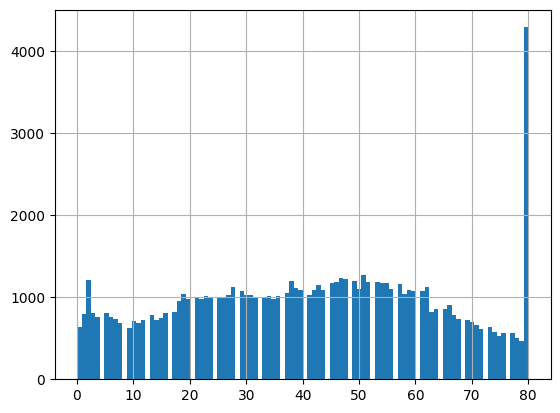

In [183]:
df_train["age"].hist(bins=100)

<Axes: >

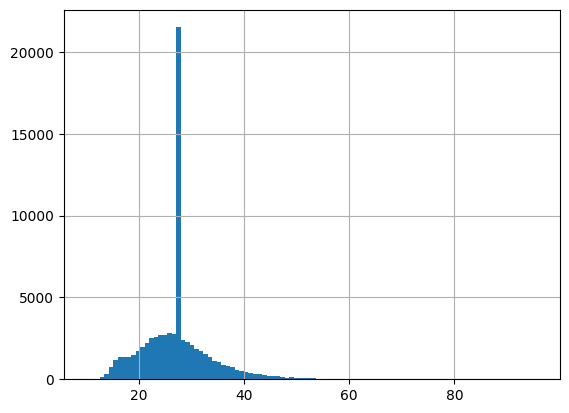

In [184]:
df_train["bmi"].hist(bins=100)

<Axes: >

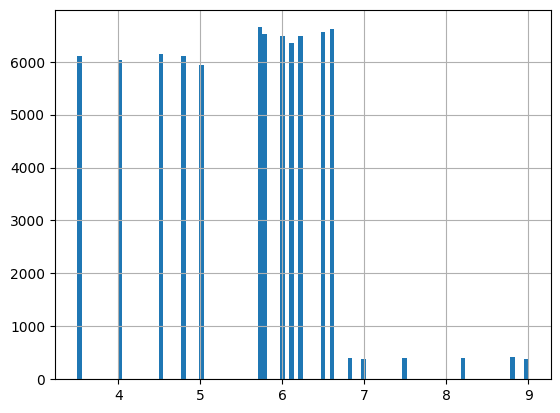

In [185]:
df_train["HbA1c_level"].hist(bins=100)

<Axes: >

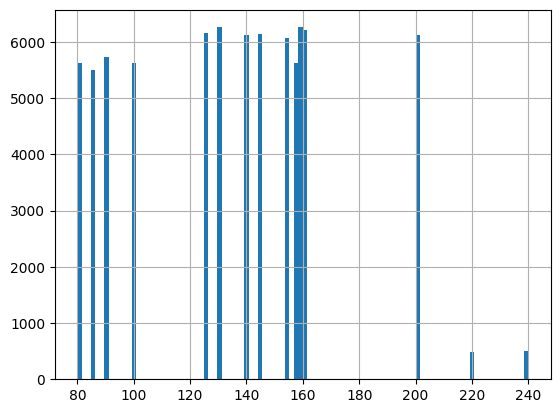

In [186]:
df_train["blood_glucose_level"].hist(bins=100)

Приведем типы столбцов датасета к корректным.

In [187]:
gender_cat = pd.CategoricalDtype(
    categories=["Female", "Male", "Other"],
    ordered=True
)

smoking_history_cat = pd.CategoricalDtype(
    categories=["No Info", "never", "current", "former",
                "not current", "ever"],
    ordered=True
)

In [188]:
df_train = df_train.astype(
    {
        "gender": gender_cat,
        "age": np.float64,
        "hypertension": np.int64,
        "heart_disease": np.int64,
        "smoking_history": smoking_history_cat,
        "bmi": np.float64,
        "HbA1c_level": np.float64,
        "blood_glucose_level": np.int64,
        "diabetes": np.int64
    }

)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78385 entries, 0 to 79999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   gender               78385 non-null  category
 1   age                  78385 non-null  float64 
 2   hypertension         78385 non-null  int64   
 3   heart_disease        78385 non-null  int64   
 4   smoking_history      78385 non-null  category
 5   bmi                  73823 non-null  float64 
 6   HbA1c_level          78385 non-null  float64 
 7   blood_glucose_level  78385 non-null  int64   
 8   diabetes             78385 non-null  int64   
dtypes: category(2), float64(3), int64(4)
memory usage: 4.9 MB


Выполним кодирование категориальных признаков и стандартизацию количественных.

Признак c индексом массы тела, пустые значения в котором будем заполнять с помощью байесовской модели, оставим без изменений.

In [189]:
num_features = ["age", "HbA1c_level", "blood_glucose_level"]
cat_features = ["gender", "hypertension","heart_disease",
                "smoking_history"]

column_transformer = ColumnTransformer([
    ("cat_transformer", OrdinalEncoder(dtype='int'), cat_features),
    ("num_transformer", StandardScaler(), num_features)
], remainder='passthrough', verbose_feature_names_out=False)

In [190]:
column_transformer.set_output(transform="pandas")
df_train = column_transformer.fit_transform(df_train)
df_train

,gender,hypertension,heart_disease,smoking_history,age,HbA1c_level,blood_glucose_level,bmi,diabetes
0,1,0,0,0,-1.308842,0.573233,0.700260,27.32,0
1,1,0,0,5,0.558642,-0.663863,0.559169,36.58,0
2,0,0,0,0,-0.152780,-1.900960,0.276986,22.31,0
3,0,0,0,0,-0.019389,0.478072,0.559169,23.62,0
4,0,1,1,4,1.714704,1.905490,0.700260,22.67,1
...,...,...,...,...,...,...,...,...,...
79995,1,0,0,0,-1.838852,0.573233,-1.557203,11.10,0
79996,0,0,0,3,-0.819739,0.668394,-1.275020,21.01,0
79997,0,0,0,4,0.158467,0.668394,0.643824,29.06,0
79998,0,0,0,4,0.202931,0.478072,-0.259162,36.09,0


Поставим __задачу классификации__ следующим образом: предсказать вероятность развития диабета по его характеристикам, представленным в датасете. Одновременно с решением задачи классификации следует заполнить пропуски в столбце "Индекс массы тела". Требуется визуализовать априорные распределения коэффициентов байесовской модели, распределение целевой переменной для произвольного объекта тестового датасета.

Байесовскую модель зададим следующим образом. Курсивом обозначены случайные переменные, прямым шрифтом -- признаки из датасета.


$b\_gender_i \sim \mathcal{N}(0,\,1), \: i \in [0,\,2]$

$b\_age \sim \mathcal{N}(0,\,1)$

$b\_hypertension_i \sim \mathcal{N}(0,\,1), \: i \in [0,\,1]$

$b\_heart\_disease_i \sim \mathcal{N}(0,\,1), \: i \in [0,\,1]$

$b\_smoking\_history_i \sim \mathcal{N}(0,\,1), \: i \in [0,\,5]$

$b\_bmi \sim \mathcal{N}(0,\,1)$

$b\_HbA1c\_level \sim \mathcal{N}(0,\,1)$

$b\_blood\_glucose\_level \sim \mathcal{N}(0,\,1)$

$mu\_bmi \sim \mathcal{N}(0,\,1)$

$std\_bmi \sim |\mathcal{N}(0,\,1)|$

$impute\_bmi \sim \mathcal{N}(mu\_bmi,\,std\_bmi)$

$bmi \sim \mathcal{N}(mu\_bmi,\,std\_bmi)$


$logits_i = b\_gender \cdot \text{gender} + b\_age \cdot \text{age} + b\_hypertension \cdot \text{hypertension} + b\_heart\_disease \cdot \text{heart_disease} + b\_smoking\_history \cdot \text{smoking_history} + b\_HbA1c\_level \cdot \text{HbA1c_level} + b\_blood\_glucose\_level \cdot \text{blood_glucose_level} + b\_bmi \cdot
  \begin{cases}
    \text{bmi}_i     & \text{if bmi$_i$ is not None}, \\
    impute\_bmi & \text{otherwise}.
  \end{cases}
$

\begin{cases}
    \text{bmi} = \sum_{i=1}^N \mathcal{N}(mu\_bmi,\,std\_bmi)
    & \text{if loan_int_rate$_i$ is not None}, \\
    impute\_bmi = \sum_{i=1}^N \mathcal{N}(mu\_bmi,\,std\_bmi) & \text{otherwise}.
\end{cases}

$\text{diabetes} = \prod_{i=1}^{N} \mathcal B \left[ {\sigma(logits_i)} \right]$

In [193]:
from __future__ import barry_as_FLUFL
def model(data: pd.DataFrame, y: pd.Series | None = None):
    b_age = pyro.sample("b_age", dist.Normal(0, 1))
    b_bmi = pyro.sample("b_bmi", dist.Normal(0, 1))
    b_HbA1c_level = pyro.sample("b_HbA1c_level", dist.Normal(0, 1))
    b_blood_glucose_level = pyro.sample("b_blood_glucose_level",
                                        dist.Normal(0, 1))


    logits = b_age * torch.tensor(data["age"].values)
    logits += b_HbA1c_level * torch.tensor(data["HbA1c_level"].values)
    logits += b_blood_glucose_level * torch.tensor(data["blood_glucose_level"].values)

    mu_bmi = pyro.sample("mu_bmi", dist.Normal(0, 1))
    std_bmi = pyro.sample("std_bmi", dist.HalfNormal(1))

    impute_bmi = pyro.sample(
        "impute_bmi", dist.Normal(
            mu_bmi,
            std_bmi
        ).mask(False)
    )

    bmi = torch.tensor(data["bmi"].values)
    bmi = torch.where(torch.isnan(bmi),
                                impute_bmi,
                                bmi)


    logits += b_bmi * bmi

    b_gender = pyro.sample("b_gender",dist.Normal(0, 1).expand([3]))
    b_hypertension = pyro.sample("b_hypertension", dist.Normal(0, 1).expand([2]))
    b_heart_disease = pyro.sample("b_heart_disease",
                                              dist.Normal(0, 1).expand([2]))
    b_smoking_history = pyro.sample("b_smoking_history",
                                              dist.Normal(0, 1).expand([6]))

    logits += b_gender[data["gender"].to_numpy()]
    logits += b_hypertension[data["hypertension"].to_numpy()]
    logits += b_heart_disease[data["heart_disease"].to_numpy()]
    logits += b_smoking_history[data["smoking_history"].to_numpy()]

    obs = None if y is None else torch.tensor(y.values, dtype=torch.float64)

    for i in pyro.plate("N", len(data.index)):
        pyro.sample("bmi", dist.Normal(mu_bmi,
                                        std_bmi
                                      ), obs=bmi)
        return pyro.sample("diabetes",
                           dist.Bernoulli(logits=logits),
                           obs=obs)

Визуализируем графическую вероятностную модель, соответствующую совместному распределению данных и весов.

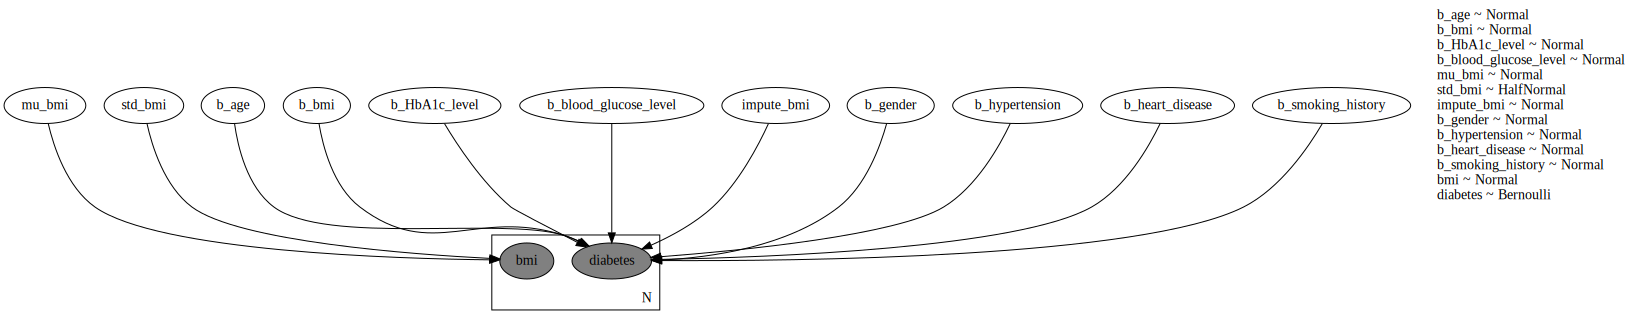

In [194]:
pyro.render_model(model,
                  model_args=(df_train, df_train["diabetes"]),
                  render_distributions=True,
                  render_params=True)

Выполним **инференс модели** с использованием марковских последовательностей Монте-Карло (MCMC).

Данная процедура выполняет нахождение апостериорного распределения весов модели, многократно сэмплируя из совместного распределения и приводя распределение сэмплов к апостериорному распределению весов.

Процедура сэмплирования может быть __достаточно длительной__.

In [195]:
num_of_samples = 200

mcmc = MCMC(NUTS(model, jit_compile=True), num_samples=num_of_samples)
mcmc.run(df_train, df_train["diabetes"])
mcmc.summary()

Warmup:   0%|          | 0/400 [00:00, ?it/s]<ipython-input-193-1d4bb70096d9>:10: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  logits = b_age * torch.tensor(data["age"].values)
<ipython-input-193-1d4bb70096d9>:11: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  logits += b_HbA1c_level * torch.tensor(data["HbA1c_level"].values)
<ipython-input-193-1d4bb70096d9>:12: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if y


                             mean       std    median      5.0%     95.0%     n_eff     r_hat
          b_HbA1c_level      2.45      0.04      2.45      2.38      2.52    219.95      1.00
                  b_age      1.04      0.03      1.04      1.00      1.10    159.76      1.00
  b_blood_glucose_level      0.97      0.02      0.97      0.94      1.01    133.97      1.00
                  b_bmi      0.08      0.00      0.08      0.08      0.09    177.88      1.00
            b_gender[0]     -2.02      0.56     -1.99     -2.91     -1.16     52.17      1.00
            b_gender[1]     -1.75      0.56     -1.75     -2.51     -0.78     52.19      0.99
            b_gender[2]     -0.99      0.77     -0.95     -2.32      0.12    104.96      1.00
     b_heart_disease[0]     -2.39      0.62     -2.34     -3.27     -1.14     34.74      1.00
     b_heart_disease[1]     -1.67      0.62     -1.63     -2.54     -0.38     35.32      1.00
      b_hypertension[0]     -2.68      0.62     -2.68     -

После выполнения процедуры сэмплирования проверьте значения "r_hat" в сводке параметров. Они должны быть близкими к единице, что указывает на сходимость метода.

Получить сэмплы из апостериорного распределения весов можно следующим образом:

In [196]:
posterior_samples = mcmc.get_samples()
posterior_samples

{'b_HbA1c_level': tensor([2.5131, 2.4935, 2.4992, 2.4195, 2.4391, 2.4756, 2.3976, 2.5205, 2.4406,
         2.4472, 2.4655, 2.4288, 2.4823, 2.4579, 2.4793, 2.4339, 2.4699, 2.4254,
         2.3974, 2.4854, 2.4349, 2.4225, 2.4266, 2.4205, 2.4925, 2.4986, 2.4736,
         2.4405, 2.4907, 2.4085, 2.4637, 2.4502, 2.5017, 2.4559, 2.4721, 2.4935,
         2.3976, 2.4256, 2.5165, 2.3800, 2.4387, 2.3560, 2.3622, 2.3935, 2.3829,
         2.5381, 2.4148, 2.5110, 2.3950, 2.4056, 2.4697, 2.3956, 2.4536, 2.4555,
         2.4592, 2.4231, 2.4280, 2.5073, 2.4400, 2.4342, 2.4846, 2.3656, 2.5323,
         2.5284, 2.5509, 2.3846, 2.3766, 2.3686, 2.4640, 2.4707, 2.4358, 2.4652,
         2.4439, 2.4249, 2.4707, 2.4235, 2.4204, 2.3971, 2.3761, 2.5104, 2.4367,
         2.4448, 2.4707, 2.5075, 2.4715, 2.4517, 2.4462, 2.4948, 2.4469, 2.4656,
         2.3762, 2.4754, 2.4598, 2.3934, 2.5636, 2.4150, 2.4033, 2.4785, 2.4308,
         2.4610, 2.4753, 2.4517, 2.4789, 2.4490, 2.4327, 2.4617, 2.4211, 2.5349,
         2.

После выполнения инференса займёмся процедурой __предсказания__ с использованием обученной модели.

Загрузим датасет с тестовыми данными и посмотрим на него.

In [197]:
df_predict_name = "/content/test_diabetes.csv"
df_predict = pd.read_csv(df_predict_name)
df_predict

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,30.0,0,0,never,19.87,6.5,145,0
1,Female,20.0,0,0,No Info,22.29,5.0,126,0
2,Female,70.0,1,0,former,23.99,6.5,200,1
3,Female,72.0,0,0,never,27.32,6.2,80,0
4,Male,80.0,0,1,former,27.32,6.5,130,0
...,...,...,...,...,...,...,...,...,...
19995,Male,8.0,0,0,No Info,16.95,5.7,160,0
19996,Female,79.0,0,0,No Info,43.20,4.0,159,0
19997,Male,8.0,0,0,No Info,21.03,6.2,200,0
19998,Female,33.0,0,0,No Info,37.21,5.8,126,0


Выполним над тестовым датасетом те же преобразования признаков, что и над тренировочным:

In [198]:
df_predict = column_transformer.transform(df_predict)
df_predict

,gender,hypertension,heart_disease,smoking_history,age,HbA1c_level,blood_glucose_level,bmi,diabetes
0,0,0,0,4,-0.508492,0.953878,0.276986,19.87,0
1,0,0,0,0,-0.953131,-0.473541,-0.259162,22.29,0
2,0,1,0,3,1.270065,0.953878,1.828992,23.99,1
3,0,0,0,4,1.358993,0.668394,-1.557203,27.32,0
4,1,0,1,3,1.714704,0.953878,-0.146288,27.32,0
...,...,...,...,...,...,...,...,...,...
19995,1,0,0,0,-1.486698,0.192588,0.700260,16.95,0
19996,0,0,0,0,1.670240,-1.425153,0.672042,43.20,0
19997,1,0,0,0,-1.486698,0.668394,1.828992,21.03,0
19998,0,0,0,0,-0.375100,0.287749,-0.259162,37.21,0


Получим распределение наблюдаемых переменных для каждого объекта из тестовой выборки с использованием апостериорных распределений весов (полученных после обучения модели).

In [199]:
posterior_predictive = Predictive(model, posterior_samples)(df_predict)
posterior_predictive

{'diabetes': tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64),
 'bmi': tensor([[19.8700, 22.2900, 23.9900,  ..., 21.0300, 37.2100, 22.3000],
         [19.8700, 22.2900, 23.9900,  ..., 21.0300, 37.2100, 22.3000],
         [19.8700, 22.2900, 23.9900,  ..., 21.0300, 37.2100, 22.3000],
         ...,
         [19.8700, 22.2900, 23.9900,  ..., 21.0300, 37.2100, 22.3000],
         [19.8700, 22.2900, 23.9900,  ..., 21.0300, 37.2100, 22.3000],
         [19.8700, 22.2900, 23.9900,  ..., 21.0300, 37.2100, 22.3000]],
        dtype=torch.float64)}

Получим распределение наблюдаемых переменных для каждого объекта из тестовой выборки с использованием априорных распределений весов (полученных до обучения модели).

In [200]:
prior = Predictive(model, num_samples=num_of_samples)(df_predict)
prior

{'b_age': tensor([-0.4983, -1.4714,  0.4516, -0.9290, -0.7768, -0.7643, -0.6441, -0.4399,
         -1.2628, -0.3644, -1.0879,  1.0471,  0.5073,  0.4677, -0.7935,  0.4054,
          0.4928,  0.4376, -1.2076,  1.8264, -0.5610, -0.2219, -0.7384, -0.9740,
          1.3996, -0.7910,  0.3882, -0.1275,  0.5364,  0.7786, -1.1120, -0.0824,
         -0.4493,  0.2123, -0.4929, -0.3860,  0.1922,  0.8917,  0.3735,  2.1464,
         -0.3203,  0.7982, -0.2737,  0.8403,  0.4199, -0.2506,  0.4280, -0.2818,
          0.4900, -0.0361,  0.2577, -0.7889,  0.0606, -1.2204,  0.9424,  0.1998,
         -0.0087,  2.1937, -0.4420,  1.9843, -0.9720,  0.9178,  1.1573, -0.1707,
          0.2170, -0.0295,  1.1715, -0.3348,  0.6534,  0.6431,  1.2517,  0.3080,
         -1.2092, -1.6105,  0.6459, -0.5092,  0.0171,  1.1810,  0.0504, -0.4901,
         -0.6118, -0.5836,  0.3724,  1.4687,  0.6475,  0.2043,  2.1316, -0.9632,
          0.5598,  0.7452, -0.8577, -0.3447, -0.3078,  0.1870,  1.2447,  0.4782,
          1.0874, -

Сформируем данные для визуализации с помощью библиотеки [ArViZ](https://python.arviz.org/en/stable/).

In [201]:
pyro_data = az.from_pyro(
    mcmc, prior=prior, posterior_predictive=posterior_predictive
)
pyro_data

/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Визуализируем апостериорные распределения всех латентных переменных (весов модели).

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'b_HbA1c_level'}>,
        <Axes: title={'center': 'b_age'}>,
        <Axes: title={'center': 'b_blood_glucose_level'}>,
        <Axes: title={'center': 'b_bmi'}>],
       [<Axes: title={'center': 'b_gender\n0'}>,
        <Axes: title={'center': 'b_gender\n1'}>,
        <Axes: title={'center': 'b_gender\n2'}>,
        <Axes: title={'center': 'b_heart_disease\n0'}>],
       [<Axes: title={'center': 'b_heart_disease\n1'}>,
        <Axes: title={'center': 'b_hypertension\n0'}>,
        <Axes: title={'center': 'b_hypertension\n1'}>,
        <Axes: title={'center': 'b_smoking_history\n0'}>],
       [<Axes: title={'center': 'b_smoking_history\n1'}>,
        <Axes: title={'center': 'b_smoking_history\n2'}>,
        <Axes: title={'center': 'b_smoking_history\n3'}>,
        <Axes: title={'center': 'b_smoking_history\n4'}>],
       [<Axes: title={'center': 'b_smoking_history\n5'}>,
        <Axes: title={'center': 'impute_bmi'}>,
        <Axes: title={'center': 'mu

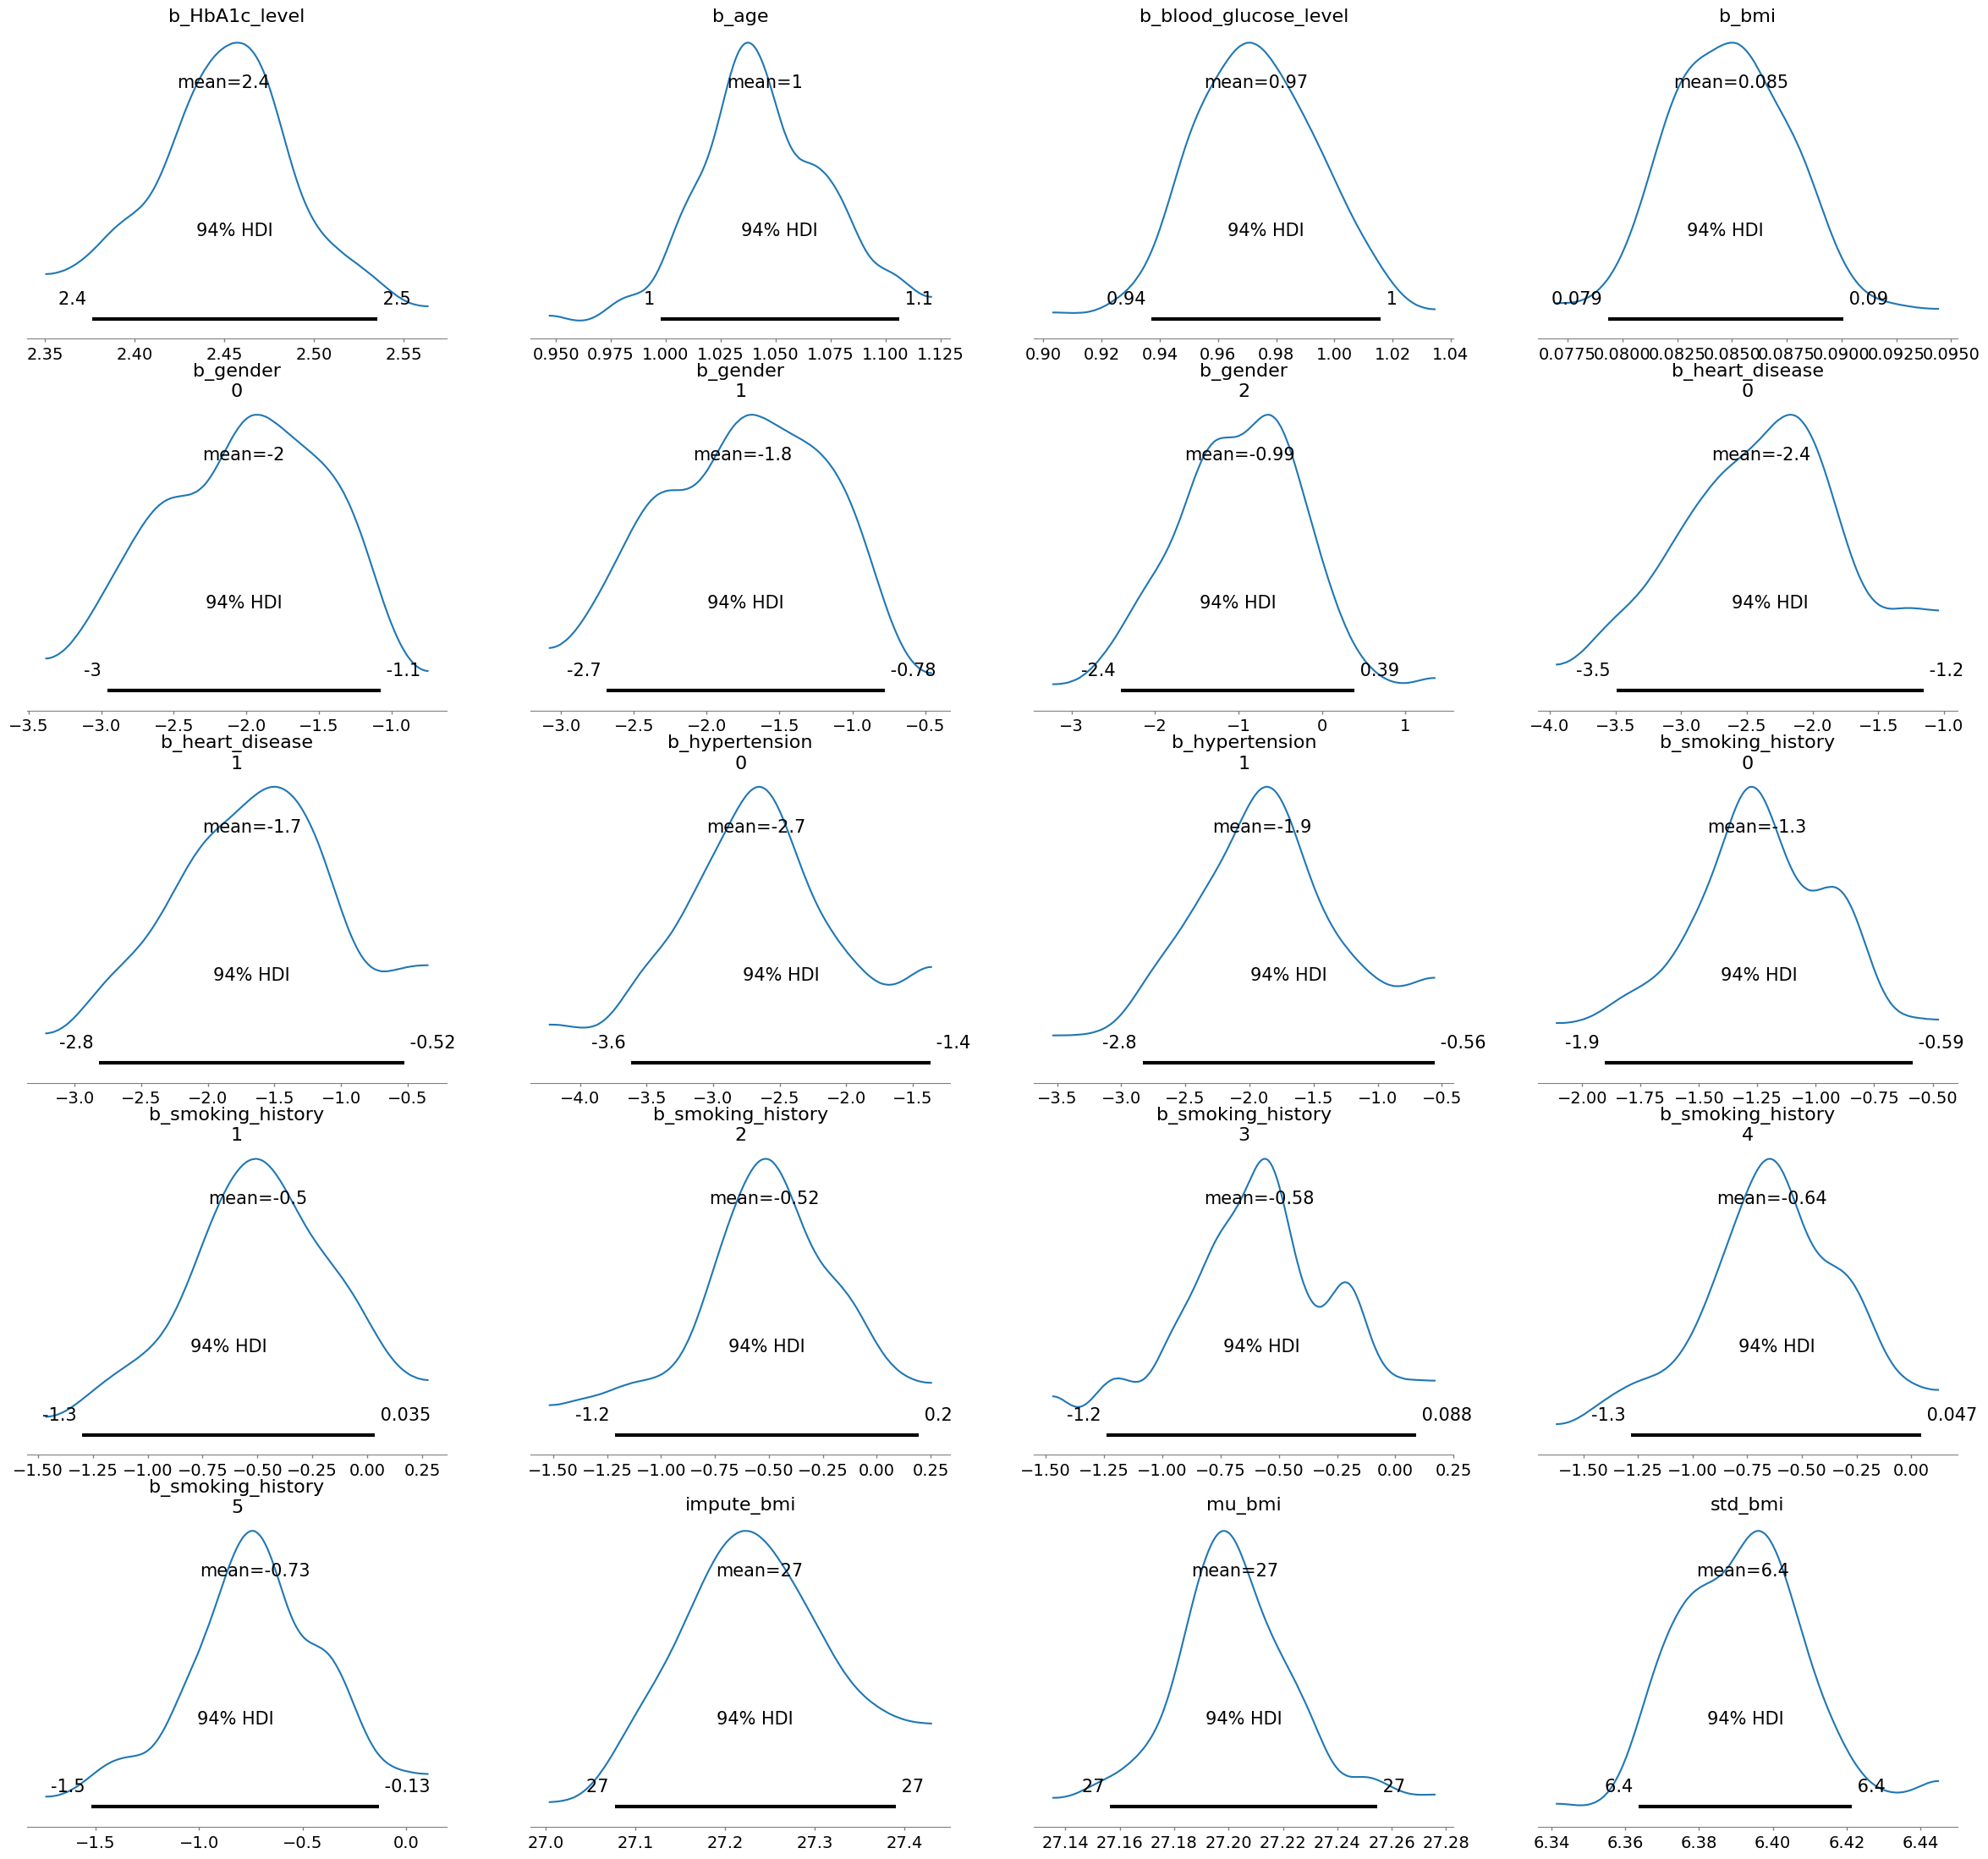

In [202]:
az.plot_posterior(pyro_data)

Визуализируем семейство распределений латентных переменных, полученных моделью, и сравним их с эмпирическим распределением, сформированным из тестового датасета.

array([<Axes: xlabel='bmi / bmi'>, <Axes: xlabel='diabetes / diabetes'>],
      dtype=object)

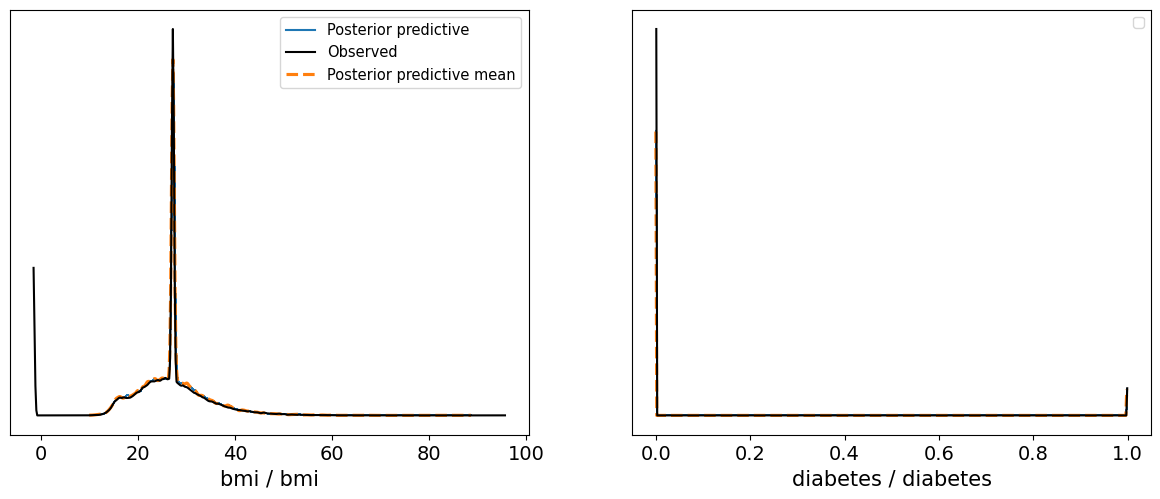

In [203]:
az.plot_ppc(pyro_data)

Посмотрим на апостериорные распределения латентных переменных (весов модели) всесте с "трассой" -- набором сэмплов, полученных в процессе выполнения инференса методом MCMC.

array([[<Axes: title={'center': 'b_HbA1c_level'}>,
        <Axes: title={'center': 'b_HbA1c_level'}>],
       [<Axes: title={'center': 'b_age'}>,
        <Axes: title={'center': 'b_age'}>],
       [<Axes: title={'center': 'b_blood_glucose_level'}>,
        <Axes: title={'center': 'b_blood_glucose_level'}>],
       [<Axes: title={'center': 'b_bmi'}>,
        <Axes: title={'center': 'b_bmi'}>],
       [<Axes: title={'center': 'b_gender'}>,
        <Axes: title={'center': 'b_gender'}>],
       [<Axes: title={'center': 'b_heart_disease'}>,
        <Axes: title={'center': 'b_heart_disease'}>],
       [<Axes: title={'center': 'b_hypertension'}>,
        <Axes: title={'center': 'b_hypertension'}>],
       [<Axes: title={'center': 'b_smoking_history'}>,
        <Axes: title={'center': 'b_smoking_history'}>],
       [<Axes: title={'center': 'impute_bmi'}>,
        <Axes: title={'center': 'impute_bmi'}>],
       [<Axes: title={'center': 'mu_bmi'}>,
        <Axes: title={'center': 'mu_bmi'}>],
  

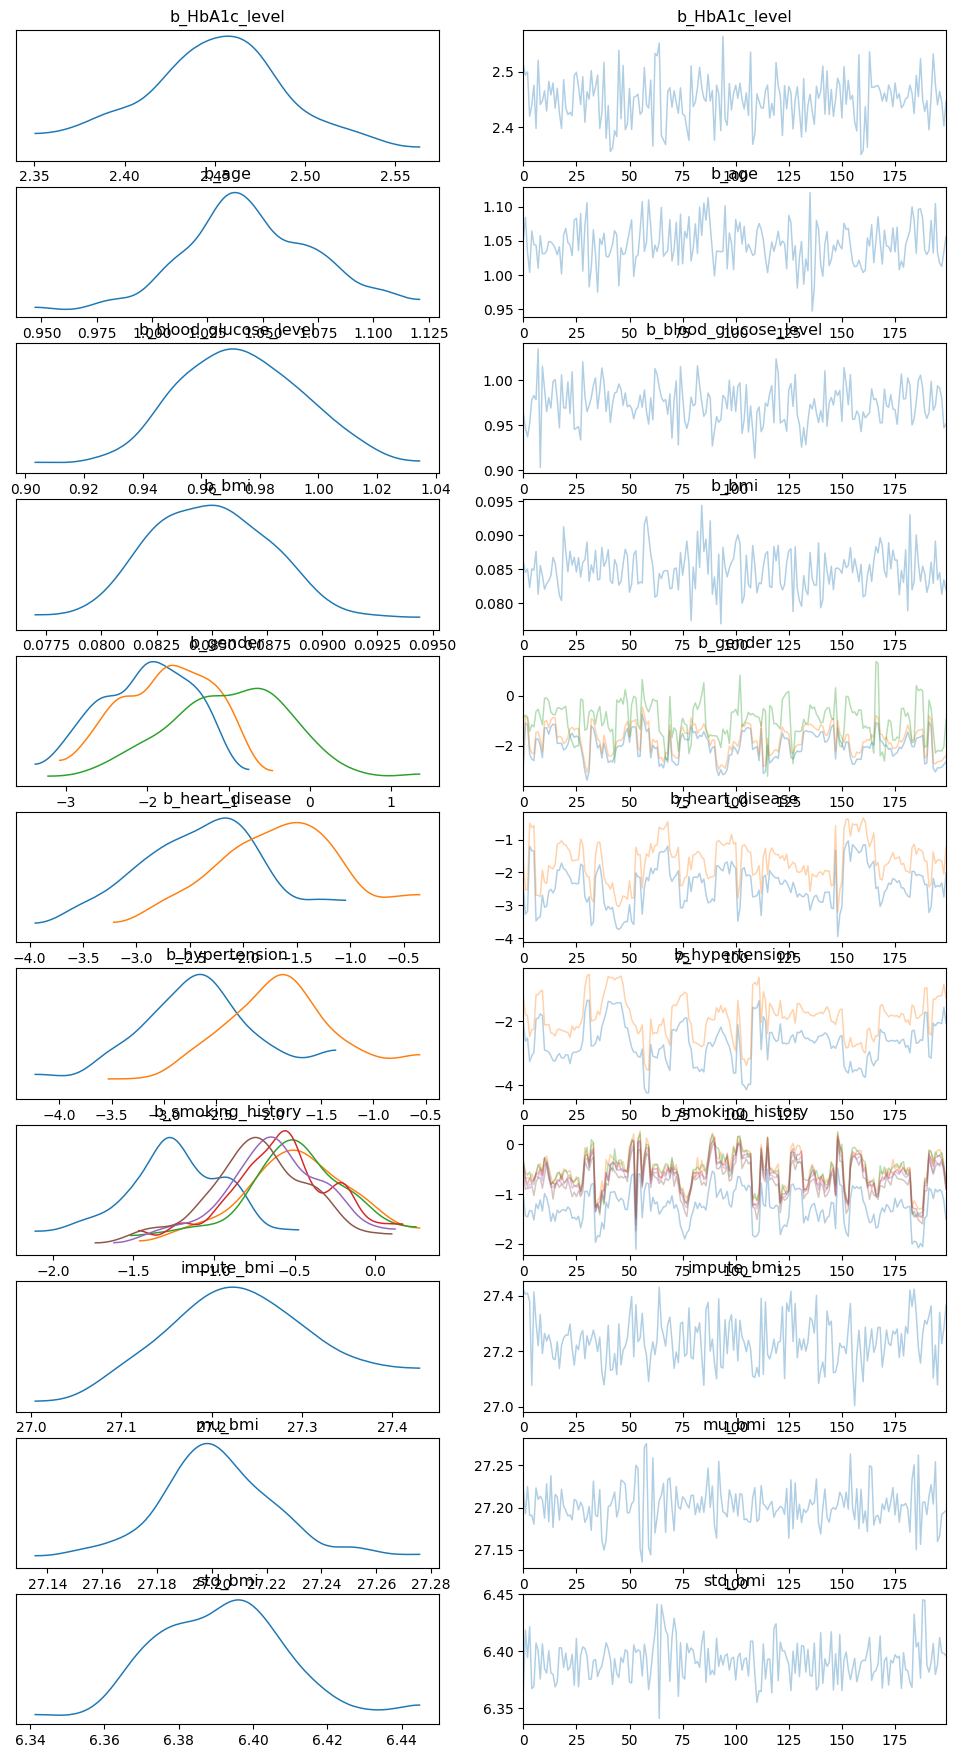

In [204]:
az.plot_trace(pyro_data)

Визуализируем распределение переменной наличия диабеда (целевая бинарная переменная, показывающая, есть ли у пациента диабед) для одного случайного пациента. Красной пунктирной линией показано истинное значение целевой переменной у данного объекта.

Ground True value:  0
Probability of label to be one:  0.39
Distribution:


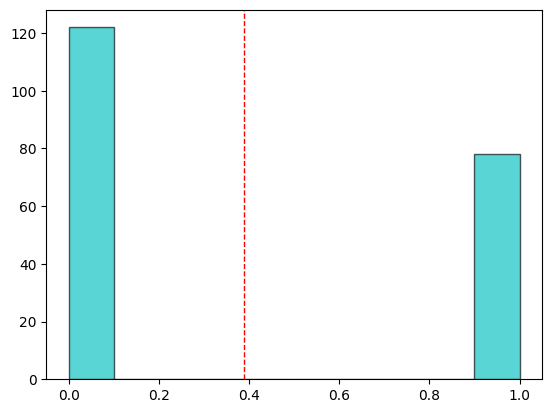

In [205]:
df_predict_one = df_predict.sample(n=1)

posterior_predictive_one = Predictive(model, posterior_samples)(df_predict_one)
ser = pd.Series(
    posterior_predictive_one["diabetes"].detach().numpy().squeeze()
)
print("Ground True value: ", df_predict_one["diabetes"].values.squeeze())
print("Probability of label to be one: ", ser.mean())
print("Distribution:")
result = plt.hist(ser, color='c', edgecolor='k', alpha=0.65)
plt.axvline(ser.mean(), color='r', linestyle='dashed', linewidth=1)